In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import LearningCurve


---

## № 1

1. Загрузите предложенный вам датасет с помощью функции `sklearn.datasets.fetch_openml`.
2. Выведите текстовое описание загруженного датасета.
3. Определите какая бизнес-задача ставится.
4. Переведите бизнес-задачу в задачу машинного обучения.


In [137]:
# Загружаем датасет
# ! Если не указать версию загрузится самая первая, с не правильным описанием
dataset = fetch_openml("cloud", version=1)
dataset.data.head(5)


,seeded,season,NC,SC,NWC
0,S,AUTUMN,1.65,1.80,3.33
1,U,AUTUMN,1.09,0.79,1.59
2,S,WINTER,2.39,0.36,2.06
3,U,WINTER,2.96,1.27,4.05
4,S,WINTER,4.16,2.16,6.00


In [141]:
dataset.target.head(5)

0    1.69
1    0.74
2    0.81
3    1.44
4    2.48
Name: TE, dtype: float64

In [86]:
# Описание датасета
print(dataset.DESCR)

**Author**:   
**Source**: Unknown -   
**Please cite**:   

Data from StatLib (ftp stat.cmu.edu/datasets)

 These data are those collected in a cloud-seeding experiment in Tasmania
 between mid-1964 and January 1971.   Their analysis, using regression
 techniques and permutation tests, is discussed in:
 
       Miller, A.J., Shaw, D.E., Veitch, L.G. & Smith, E.J. (1979).
       `Analyzing the results of a cloud-seeding experiment in Tasmania',
       Communications in Statistics - Theory & Methods, vol.A8(10),
       1017-1047.
 
 The rainfalls are period rainfalls in inches.   TE and TW are the east and
 west target areas respectively, while NC, SC and NWC are the corresponding
 rainfalls in the north, south and north-west control areas respectively.
 S = seeded, U = unseeded.

 Rain in eastern target region is being treated
 as the class attribute. (Attribute for rain
 in the western target region has been deleted.)

Downloaded from openml.org.


In [87]:
# Описание пишите сами

---

## № 2

1. Проведите предварительный анализ датасета.
2. Выведите основную статистическую информацию о данных.
3. Проверьте дисбаланс целевого признака.


In [88]:
X = dataset.data
y = dataset.target

In [89]:
# Переведем катеригориальные переменные в числовые
for col in X.columns:
    if not pd.api.types.is_numeric_dtype(X[col].dtype):
        X.loc[:, col] = X[col].astype("category").cat.codes

y = y.astype("category").cat.codes
X.head(5)


,seeded,season,NC,SC,NWC
0,0,0,1.65,1.80,3.33
1,1,0,1.09,0.79,1.59
2,0,3,2.39,0.36,2.06
3,1,3,2.96,1.27,4.05
4,0,3,4.16,2.16,6.00


In [90]:
# Статистика по катеригориальным данным не выводится
X.describe()

,seeded,season,NC,SC,NWC
count,108.000000,108.000000,108.000000,108.000000,108.000000
mean,0.500000,1.518519,1.506389,1.202130,2.192870
std,0.502331,1.106324,1.431687,0.891783,1.632942
min,0.000000,0.000000,0.000000,0.020000,0.040000
25%,0.000000,1.000000,0.410000,0.535000,0.882500
50%,0.500000,1.000000,1.285000,0.995000,1.915000
75%,1.000000,3.000000,2.132500,1.662500,3.050000
max,1.000000,3.000000,9.420000,4.020000,7.840000


In [91]:
# Это регрессия, не будем строить дисбаланс

---

## № 3

1. Убедитесь, что данные пригодны для моделирования.
2. В данных не должно быть пропущенных значений, все признаки должны быть численными.
3. Если эти условия нарушаются, исправьте это.


Тк мы уже заменили все данные на численные, осталось проверить на пропуски


In [92]:
X.isna().any(axis=0)

seeded    False
season    False
NC        False
SC        False
NWC       False
dtype: bool

In [93]:
y.isna().any()

False

Везде False, пропущенных значений нет


Если бы были пропущенные значения, мы могли бы заменить их используя следующий код

`y = y.fillna(y.mean())`


---

## № 4

1. Обучите любую линейную модель, которая решает поставленную задачу.
2. Выведите с помощью метода `score()` результат метрики оценки модели.
3. Опишите какая метрика подсчитывается в методе `score()`.


In [94]:
# Обучим модель, добавив фиктивную переменную
linear = LinearRegression().fit(sm.add_constant(X), y)
y_pred = linear.predict(sm.add_constant(X))
y_pred_proba = linear.predict(sm.add_constant(X))

In [95]:
# Выведем метрику точности
linear.score(sm.add_constant(X), y)
# У линейной модели по умолчанию считает mean_accuracy

0.7945816279142529

---

## № 5

1. К поставленной задачи машинного обучения подберите еще 3 метрики.
2. С помощью их оцените обученную линейную модель.


In [96]:
print(f"max_error: {max_error(y, y_pred):.4f}")
print(f"mean_absolute_error: {mean_absolute_error(y, y_pred):.4f}")
print(f"mean_squared_error: {mean_squared_error(y, y_pred):.4f}")


max_error: 44.8199
mean_absolute_error: 9.4028
mean_squared_error: 142.7157


In [97]:
# Повторим оценку используя кросс-валидацию

# Разбиваем датасет
skf = KFold(n_splits=20, shuffle=True, random_state=1223)

# Приминяем метрики
for metric in (
    "max_error",
    "neg_mean_absolute_percentage_error",
    "neg_mean_squared_error",
):
    cv_results = cross_val_score(
        LinearRegression(),  # модель
        X,  # матрица признаков
        y,  # вектор цели
        cv=skf,  # тип разбиения
        scoring=metric,  # метрика
        n_jobs=-1,
    )

    # print("Кросс-валидация: ", cv_results)
    print(f"{metric}: ", cv_results.mean())


max_error:  -21.366107001179323
neg_mean_absolute_percentage_error:  -548081377156538.4
neg_mean_squared_error:  -179.36886609096706


---

## № 6

1. Постройте совместное распределение теоретических и эмпирических значений целевой переменной.
2. Сделайте вывод о наличии либо отсутствии систематической компоненты в отклонениях, их общей величине.

<Axes: ylabel='Density'>

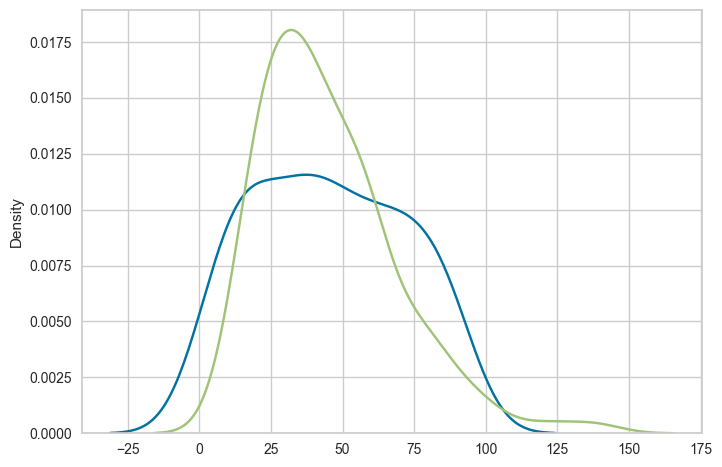

In [114]:
sns.kdeplot(y)
sns.kdeplot(y_pred)
# Судя по распределению, чем ближе значение к самым частым, тем больше разница между теоретическими и эмпирическими

Просто посмотрим на предсказания

<Axes: >

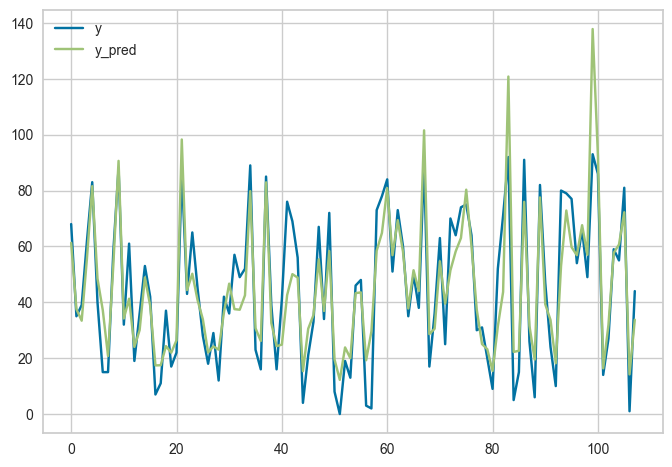

In [133]:
sns.lineplot(y, label="y")
sns.lineplot(y_pred, label="y_pred")


<Axes: >

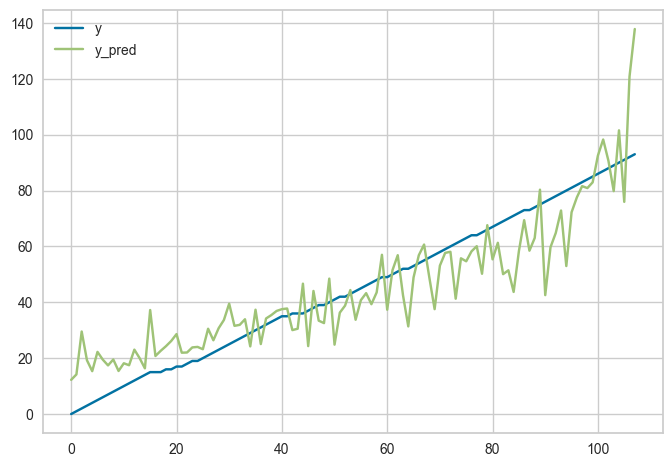

In [134]:
sort_mask = np.argsort(y)
sns.lineplot(y.values[sort_mask], label="y")
sns.lineplot(y_pred[sort_mask], label="y_pred")


---

## № 7

1. Постройте ту же модель, но с предварительной нормализацией значений признаков. 
2. Сделайте вывод о влиянии нормализации на качество работы модели.


In [109]:
# Модель с нормализацией
cv_results = cross_val_score(
    make_pipeline(StandardScaler(), LinearRegression()),  # модель
    X,  # матрица признаков
    y,  # вектор цели
    cv=skf,  # тип разбиения
    scoring="r2",  # метрика
    n_jobs=-1,
)
cv_results.mean()


0.6590582344009265

In [108]:
# Модель без нормализации
cv_results = cross_val_score(
    LinearRegression(),  # модель
    X,  # матрица признаков
    y,  # вектор цели
    cv=skf,  # тип разбиения
    scoring="r2",  # метрика
    n_jobs=-1,
)
cv_results.mean()


0.6590582344009265

Странно, но в данном случае нормализация ничего не изменила

---

## № 8

1. Обоснуйте выбор типа разбиения данных при кросс-валидации для вашей задачи машинного обучения.
2. Обучите любую другую модель используя кросс-валидацию данных.


Выше использовалась кросс-валидация, метод `KFold` был взят из-за отсутствия сильного дизбаланса в целевом классе


Обучим другую модель и проведем кросс-валидацию


In [98]:
# У модели ближайших соседей тоже получилась хорошая точность
res = cross_val_score(
    KNeighborsRegressor(),  # модель
    X,  # матрица признаков
    y,  # вектор цели
    cv=skf,  # тип разбиения
    scoring="r2",  # метрика
    n_jobs=-1,
)
res.mean()


0.6658022286218426

---

## № 9

1. Проведите диагностику любой модели.
2. Постройте кривые обучения.
3. Сделайте вывод о переобученности или недообученности модели.


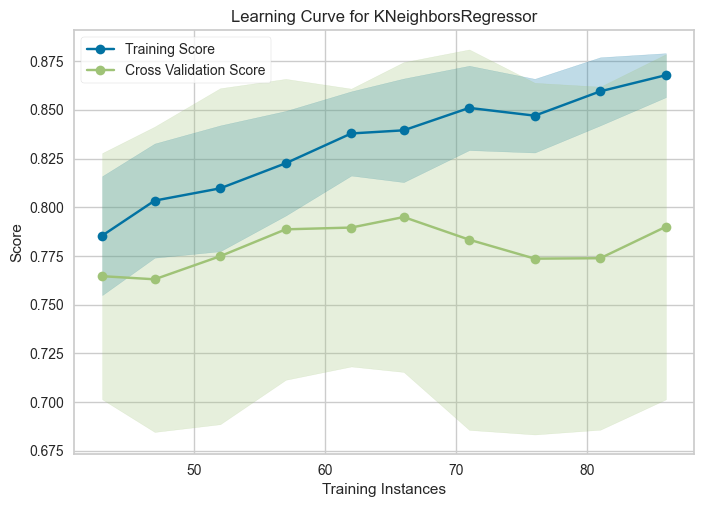

In [99]:
visualizer = (
    LearningCurve(KNeighborsRegressor(), train_sizes=np.linspace(0.5, 1.0, 10))
    .fit(X, y)
    .show()
)
# Модель немного переобучена, что видна по промежутку между кривыми


---

## № 10

1. Исследуйте как любой из гиперпараметров модели влияет на эффективность модели.


Text(0, 0.5, 'accuracy')

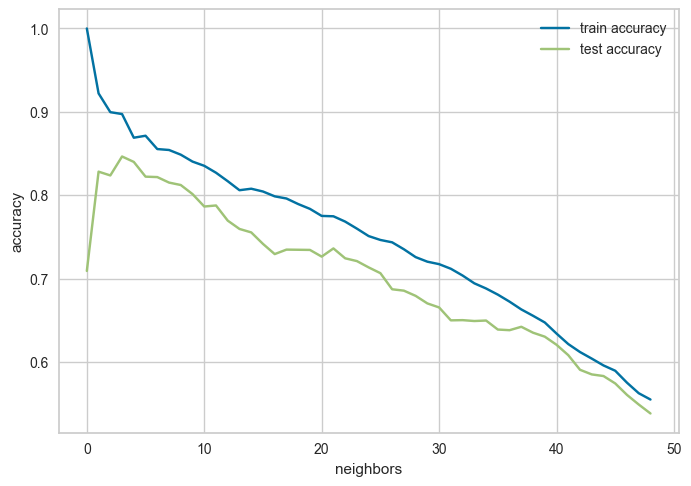

In [100]:
# Построим график влияния количества соседей на эффективностьт модели
scores_train = []
scores_test = []
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1223
)
for neighbors in range(1, 50):
    model = KNeighborsRegressor(neighbors).fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    scores_train.append(r2_score(y_train, y_pred_train))
    scores_test.append(r2_score(y_test, y_pred_test))

plt.plot(scores_train, label="train accuracy")
plt.plot(scores_test, label="test accuracy")
plt.legend()
plt.xlabel("neighbors")
plt.ylabel("accuracy")


В начале при увеличении количества сосдей эффективность возрастает, н примерно с 6 соседей начинает падать